# Machine Learning in Python - Workshop 6

# 1. Setup


## 1.1 Packages


In the cell below we will load the core libraries we will be using for this workshop and setting some sensible defaults for our plot size and resolution. 

In [ ]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

## 1.2 Helper Functions



In [ ]:
def plot_boundaries(bounds, x='lon', y='lat', group='precinct', n=5):
    """ Draws boundary lines for a series of groups polygons in a dataframe
    """
    sns.lineplot(x=x, y=y, hue=group, data=bounds,
                 sort=False, palette=['k']*n, legend=None)

def roc_plot(y_true, y_pred):
    """ Draw an ROC curve and report AUC
    """
    roc = pd.DataFrame(
        data = np.c_[sklearn.metrics.roc_curve(y_true, y_pred)],
        columns = ('fpr', 'tpr', 'threshold')
    )
    
    sns.lineplot(x='fpr', y='tpr', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.title("ROC curve (auc = %.4f)" % sklearn.metrics.roc_auc_score(y_true, y_pred))
             
    plt.show()

## 1.3 Data

The data for this workshop comes from New York City's [Open Data project](https://opendata.cityofnewyork.us/). Specifically we will be looking at parking tickets issued in Fiscal Year 2019 in the borough of Manhattan in New York city. The data has been preprocessed and subset so that we will be working with a random sample of tickets issued by southern Manhattan's 1st, 5th, 6th, 7th or 9th police precincts during this period. These data only contain columns for the issuing precinct, citation address, and the longitude and latitude of the address. 

* `precinct` - This is the police precinct that issued the parking ticket.
* `address` - The location where the parking ticket was issued
* `longitude` & `latitude` - The spatial coordinates obtained from geocoding the address.

These data are available in `manh_tickets.csv`, we have also provided two other files: `manh_test.csv` which contains location data with the correct police precinct label, and `manh_bounds.csv` which contains simplified boundaries for these five police precincts. Note if you are interested in looking at data for all of Manhattan's 22 police precincts, these have been included in the `full/` directory in this repository.

Our goal here is to use these parking tickets to develop a model which predicts the boundaries of the police precincts in Manhattan based only on the locations where parcking tickets have been issued. 

We read in all three data sets using pandas,

In [ ]:
manh_tickets = pd.read_csv("manh_tickets.csv")
manh_test = pd.read_csv("manh_test.csv")
manh_bounds = pd.read_csv("manh_bounds.csv")

As we will be regularly plotting these data and coloring by the precinct it is worthwhile setting up a consistent color palette that will be used for all of these plots. If we don't take this steps some of the visualizations will be inconsistent as seaborn will choose colors based on which categories are present and the order they occur in. Here we define a unique color for each police precinct and define a dictionary that can then be used as a `palette` for all of our subsequent seaborn plots.

In [ ]:
precincts = ['Precinct01', 'Precinct05', 'Precinct06', 'Precinct07', 'Precinct09']

# Create a color palette for all precincts
# colors are based on the cols25 palette from R's pals package
precinct_pal = dict(
    zip(precincts,
        [(0.894117, 0.101960, 0.109803),
         (0.215686, 0.494117, 0.721568),
         (0.301960, 0.686274, 0.290196),
         (0.596078, 0.305882, 0.639215),
         (1,        0.4980392, 0)]
    )
)

To see the mapping of colors to precincts we can use seaborn's `palplot` function and add text labels for each of the precincts.

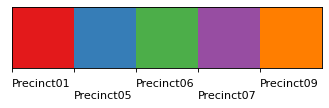

In [ ]:
sns.palplot(precinct_pal.values())
for x, key in zip(range(0,22), precinct_pal.keys()):
    plt.text(x-0.5, 0.8 + (x % 2) * 0.2, s = key)

Using our new palette we can now plot the parking ticket data and the true precinct data using scatter plots, we add the precinct boundaries using `plot_boundaries` to make everything more readable.

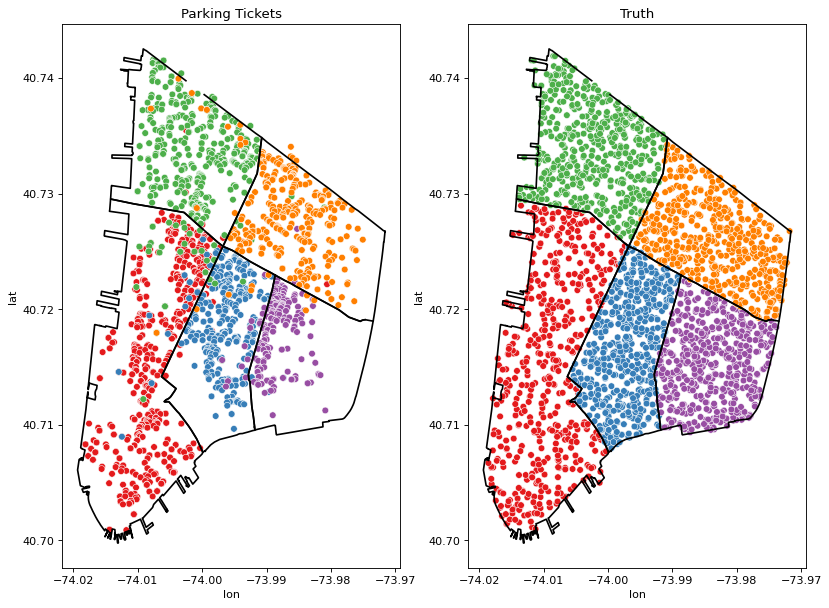

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(121)
sns.scatterplot(
    x='lon', y='lat', hue='precinct', palette=precinct_pal,
    data=manh_tickets, legend=None
).set_title("Parking Tickets")
plot_boundaries(manh_bounds)

plt.subplot(122)
sns.scatterplot(
    x='lon', y='lat', hue='precinct', palette=precinct_pal,
    data=manh_test, legend=None
).set_title("Truth")
plot_boundaries(manh_bounds)

plt.show()

---

### &diams; Exercise 1

Compare the data from the parking tickets to the correctly labeled police precinct data. Are there any clear patterns in the ticket data?

*Generally the tickets are located within the correct precincts, however there is a non-negligible number of tickets that cross the boundaries. Additionally, certain regions of Precincts 5 and 7 lack data.* 

--- 

# 2. Multiclass Logistic Regression

Our goal is to create a model that can use the available spatial coordinates to assign locations into one of the 5 precincts. To do this we will be fitting a logistic regression model, but instead of using a single binary variable as our outcome we will be using a 5-level categorical variable instead. Fortunately, sklearn can fit either type of model using the same `LogisticRegression` modeling object.

In [ ]:
from sklearn.linear_model import LogisticRegression

## 2.1 Single Precinct Model

We will begin by constructing a logistic regression model just for the 1st Precinct as a way of exploring these data. We will add a column to the `manh_tickets` data frame called `Precinct01` which is equal to `1` if the data comes from this specific precinct and `0` otherwise.

In [ ]:
manh_tickets['Precinct01'] = (manh_tickets.precinct == 'Precinct01').astype(int)

We can visualize the distribution of the occurrence of tickets issued by the 1st precinct by plotting  this new column for each issues ticket.

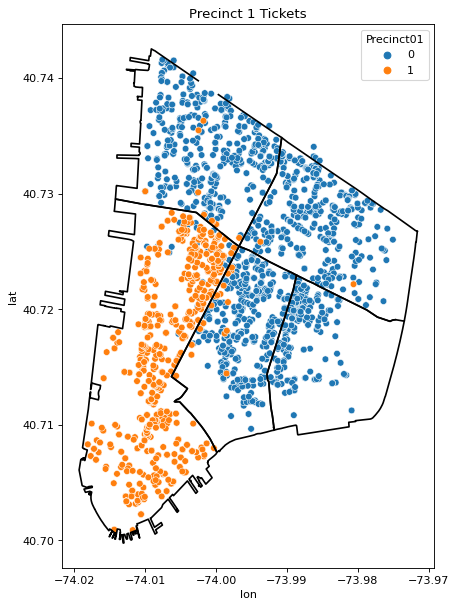

In [ ]:
plt.figure(figsize=(6,9))
sns.scatterplot(
    x='lon', y='lat', hue='Precinct01', 
    data=manh_tickets.sort_values('Precinct01') 
    # We sort on this column so Precinct01 points are not over plotted
).set_title("Precinct 1 Tickets")
plot_boundaries(manh_bounds)

In order to fit our model we then construct the model matrix `X` and outcome vector `y` for training from the ticket data,

In [ ]:
X = manh_tickets[['lon','lat']]
y = manh_tickets['Precinct01']

and then fit the model with these variables. As before, we set `penalty='none'` to avoid using an $\ell_1$ or $\ell_2$ penalty and we increase the value of `max_iter` to ensure the fitting procedure converges (not changing this value sometimes results in a warning about failure to converge).

Here we also use the `StandardScaler` transformer as the `LogisticRegression` model in sklearn can be sensitive to feature scales. Note that this should not be the case for simple logistic regression models without regularization - however, for most of the `solver`s the results can change depending on the feature scale and so scaling is strongly advised. (You can see this by commenting out the `StandardScaler` line in the pipeline below and running the subsequent code blocks showing the model predictions).

In [ ]:
m = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='none', max_iter=1000)
).fit(X, y)

We will store the testing results of this model in a new data frame called `p01` which is constructed by copying the test data and then adding new columns: `is_p1`, `pred_label`, and `pred_prob` which are self explanatory.

In [ ]:
p01 = manh_test.copy()

p01['is_p1'] = (p01.precinct == 'Precinct01').astype(int)
p01['pred_label'] = m.predict(p01[['lon','lat']])
p01['pred_prob'] = m.predict_proba(p01[['lon','lat']])[:,1] # Just retrieve probability for y=1 case

p01

,precinct,lon,lat,is_p1,pred_label,pred_prob
0,Precinct01,-74.010330,40.720485,1,1,0.953197
1,Precinct01,-74.005740,40.708015,1,1,0.973716
2,Precinct01,-74.001993,40.707750,1,1,0.909061
3,Precinct01,-74.005499,40.706179,1,1,0.979327
4,Precinct01,-74.009585,40.726523,1,1,0.838735
...,...,...,...,...,...,...
2495,Precinct09,-73.993883,40.725202,0,0,0.021851
2496,Precinct09,-73.988460,40.729783,0,0,0.001362
2497,Precinct09,-73.984370,40.725988,0,0,0.000616
2498,Precinct09,-73.989221,40.723938,0,0,0.005160


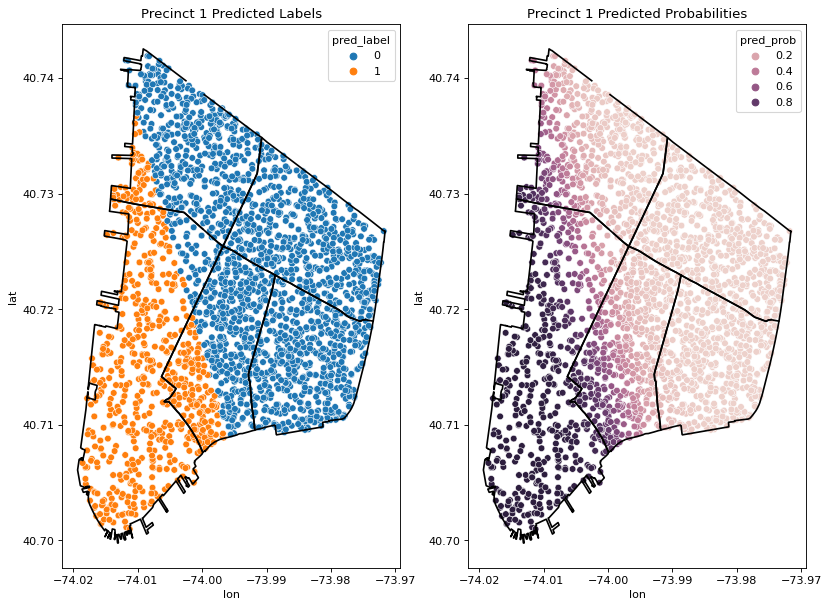

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(121)
sns.scatterplot(x='lon', y='lat', hue='pred_label', data=p01)
plot_boundaries(manh_bounds)
plt.title("Precinct 1 Predicted Labels")

plt.subplot(122)
sns.scatterplot(x='lon', y='lat', hue='pred_prob', data=p01)
plot_boundaries(manh_bounds)
plt.title("Precinct 1 Predicted Probabilities")

plt.show()

---

### &diams; Exercise 2

Describe the fit provided by this model, does it do a good job? Why or why not.

*The predictions are ok and cover most of the 1st precinct but pieces of Precinct 5 and 7 are also included. The boundary is a straight line which cannot do a great job of capturing the true boundary.*

---

We can also construct an ROC curve and calculate the AUC to obtain an numeric assessment of our model's fit.

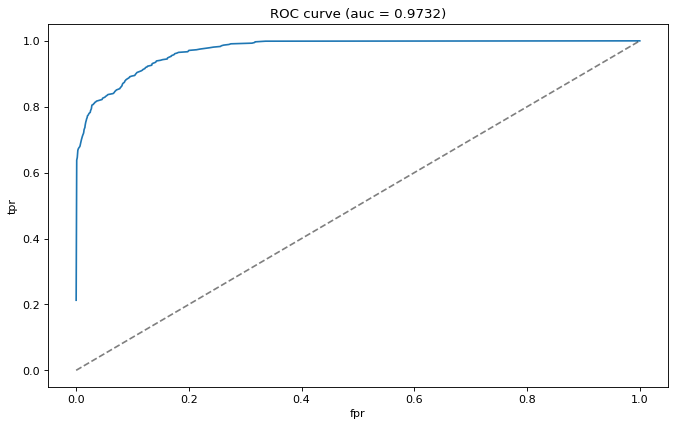

In [ ]:
roc_plot(p01.is_p1, p01.pred_prob)

---

### &diams; Exercise 3

How well does this ROC curve correspond to your answer from **Exercise 2**? Is it better or worse than you would have expected?

*The AUC for this model is quite good, and seems a bit better than one might have expected. Part of this is due to the imbalance between the Precinct 1 points vs the other precincts (there are 4x as many of the latter).*

---

### 2.2 Improving fit with interactions

Based on the model we are trying to fit here we will never be particularly successful, specifically we have a model of the form $$\text{logit}(p_i) = \beta_0 + \beta_1 \text{lon} + \beta_2 \text{lat}$$ which can only ever partition our data using a straight line. This is problematic as the police precincts have much more complex boundaries. One simple way to improve performance here is to allow more flexibility in our boudary via the includsion of an interaction term between `lat` and `lon`.

`sklearn` does not include a particularly convenient way of creating this kind of feature, but it is possible for simple interactions to construct them using the `PolynomialFeatures` transformer with the `interaction_only` argument set to `True`.

In [ ]:
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(X)

array([[  -74.00179834,    40.73629181, -3014.55885164],
       [  -74.00249384,    40.73546432, -3014.52594741],
       [  -74.01001166,    40.73019354, -3014.44209881],
       ...,
       [  -74.00086025,    40.72000407, -3013.31533056],
       [  -73.98389444,    40.71989431, -3012.61636224],
       [  -74.00708256,    40.71795383, -3013.41697077]])

As we can see this has added a new column to our model matrix that is the product of the `lat` and `long` columns (e.g. you can check that $-74.002 \times 40.736 = -3014.55$ from the first row). To use this with our model we can add this step to our pipeline and fit the resulting model.

In [ ]:
X = manh_tickets[['lon','lat']]
y = manh_tickets['Precinct01']

m = make_pipeline(
    StandardScaler(), # This order matters, scale first
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    LogisticRegression(penalty='none', max_iter=100000, verbose=False)
).fit(X, y)

We again create a copy of `manh_test` to store our modeling results.

In [ ]:
p01_int = manh_test.copy()

p01_int['is_p1'] = (p01_int.precinct == 'Precinct01').astype(int)
p01_int['pred_label'] = m.predict(p01_int[['lon','lat']])
p01_int['pred_prob'] = m.predict_proba(p01_int[['lon','lat']])[:,1]

p01_int

,precinct,lon,lat,is_p1,pred_label,pred_prob
0,Precinct01,-74.010330,40.720485,1,1,0.989094
1,Precinct01,-74.005740,40.708015,1,1,0.997844
2,Precinct01,-74.001993,40.707750,1,1,0.945500
3,Precinct01,-74.005499,40.706179,1,1,0.998474
4,Precinct01,-74.009585,40.726523,1,1,0.819697
...,...,...,...,...,...,...
2495,Precinct09,-73.993883,40.725202,0,0,0.034499
2496,Precinct09,-73.988460,40.729783,0,0,0.015866
2497,Precinct09,-73.984370,40.725988,0,0,0.001780
2498,Precinct09,-73.989221,40.723938,0,0,0.005445


and plot the resulting predicted labels and probabilities.

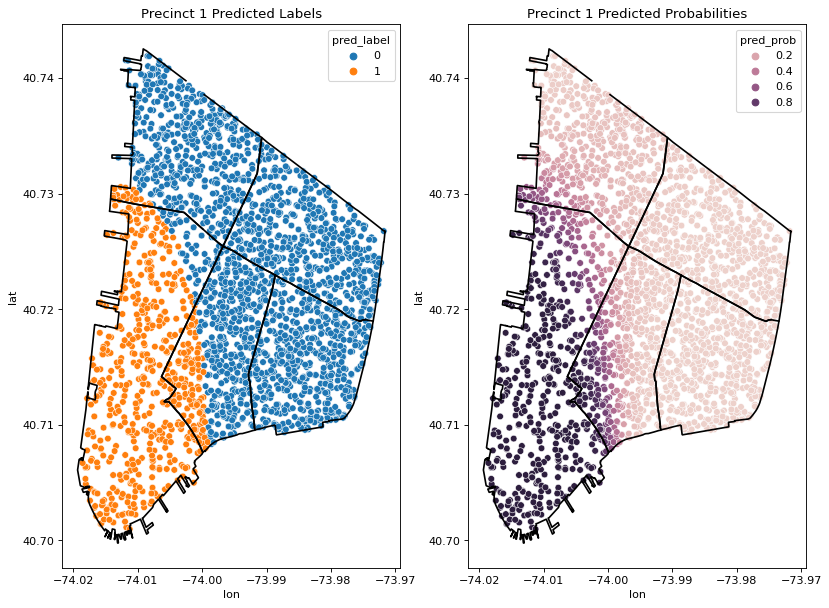

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(121)
sns.scatterplot(x='lon', y='lat', hue='pred_label', data=p01_int)
plot_boundaries(manh_bounds)
plt.title("Precinct 1 Predicted Labels")

plt.subplot(122)
sns.scatterplot(x='lon', y='lat', hue='pred_prob', data=p01_int)
plot_boundaries(manh_bounds)
plt.title("Precinct 1 Predicted Probabilities")

plt.show()

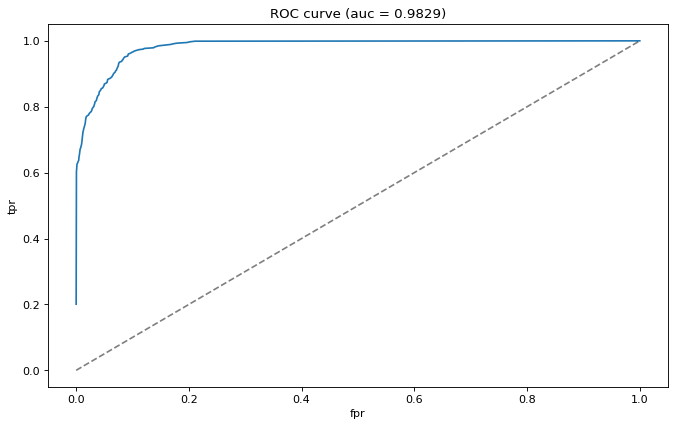

In [ ]:
roc_plot(p01_int.is_p1, p01_int.pred_prob)

---

### &diams; Exercise 4

Describe the boundary produced by this model, how does it compare to the previous model? Does this model appear to produce a better fit than the previous model?

*The boundary for this model is now curved instead of a straigh line which improves the fit somewhat. Specifically, the bit of the 6th precinct that was misclassified is much smaller. There only appears to be minor improvements in the 1st precinct false negatives and the misclassified 5th precinct points. Overall the model does have a slightly improved AUC.*

---

# 3. Multiclass classification

## 3.1 One-vs-Rest

We can imagine that the previous analysis could be extended to include all 5 precincts using a for loop or similar construction where we consider each precinct against the other 4. The only difficulty would be in the bookkeeping and storing of results. However, this is not necessary as sklearn is capable of performing this repeated model fitting of each response category versus the rest of the categories by using the `multi_class='ovr'` argument with a `LogisticRegression` model.

Below we redefine our model matrix and outcome vector, this time using the `precinct` with all 5 levels for the latter.

In [ ]:
X = manh_tickets[['lon','lat']]
y = manh_tickets.precinct

These are then fit using the following pipeline,

In [ ]:
m_ovr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='none', multi_class='ovr', max_iter=1000)
).fit(X, y)

Once we have the fitted model we can then create a similar results data frame as before and add the predicted labels for each testing location.

In [ ]:
ovr_pred = manh_test.copy()
ovr_pred['pred_label'] = m_ovr.predict(ovr_pred[['lon','lat']])

To see how we've done we can create a plot of these predicted labels and compare them to the true labels for each of the test locations.

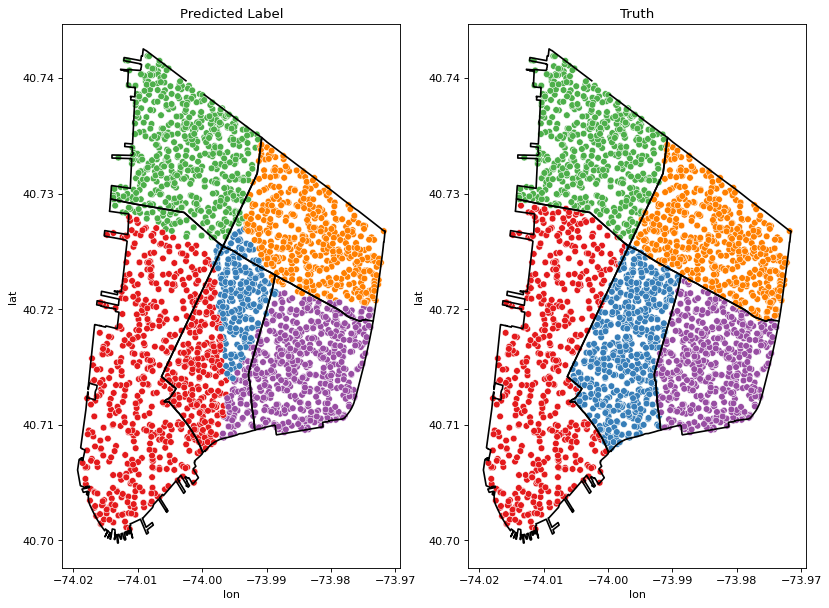

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(121)
sns.scatterplot(
    x='lon', y='lat', hue='pred_label', palette=precinct_pal,
    data=ovr_pred, legend=None
).set_title("Predicted Label")
plot_boundaries(manh_bounds)

plt.subplot(122)
sns.scatterplot(
    x='lon', y='lat', hue='precinct',  palette=precinct_pal,
    data=ovr_pred, legend=None
).set_title("Truth")
plot_boundaries(manh_bounds)

plt.show()

---

### &diams; Exercise 5

How well does this model seem to do in predicting the correct police precincts for each test location?

*This model seems to perform remarkably well - the only area of significant issue is with the 5th Precinct.*

---

We can further explore this model by examining the predicted probabilities for the different prediction locations. Note that since we are fitting 5 different models we have 5 different probabilities for each location (one for each level of the outcome vector).

In [ ]:
ovr_pred = pd.concat(
    [ ovr_pred,
    pd.DataFrame(
        # We round here for the sake of nicer printing in the table below
        data = np.round(m_ovr.predict_proba(ovr_pred[['lon','lat']]),4),
        columns = precincts
    ) ],
    axis=1
)

ovr_pred

,precinct,lon,lat,pred_label,Precinct01,Precinct05,Precinct06,Precinct07,Precinct09
0,Precinct01,-74.010330,40.720485,Precinct01,0.8335,0.0676,0.0988,0.0001,0.0000
1,Precinct01,-74.005740,40.708015,Precinct01,0.7522,0.1934,0.0001,0.0543,0.0000
2,Precinct01,-74.001993,40.707750,Precinct01,0.6157,0.2067,0.0000,0.1776,0.0000
3,Precinct01,-74.005499,40.706179,Precinct01,0.6945,0.2018,0.0000,0.1037,0.0000
4,Precinct01,-74.009585,40.726523,Precinct01,0.5266,0.0312,0.4421,0.0000,0.0001
...,...,...,...,...,...,...,...,...,...
2495,Precinct09,-73.993883,40.725202,Precinct05,0.0767,0.5041,0.1606,0.0285,0.2301
2496,Precinct09,-73.988460,40.729783,Precinct09,0.0013,0.1381,0.1384,0.0106,0.7116
2497,Precinct09,-73.984370,40.725988,Precinct09,0.0005,0.1788,0.0078,0.1483,0.6646
2498,Precinct09,-73.989221,40.723938,Precinct09,0.0090,0.3550,0.0167,0.1309,0.4884


Note that for these multiclass classification models sklearn uses what is called a softmax to determine the predicted label i.e. the class with the largest probability.

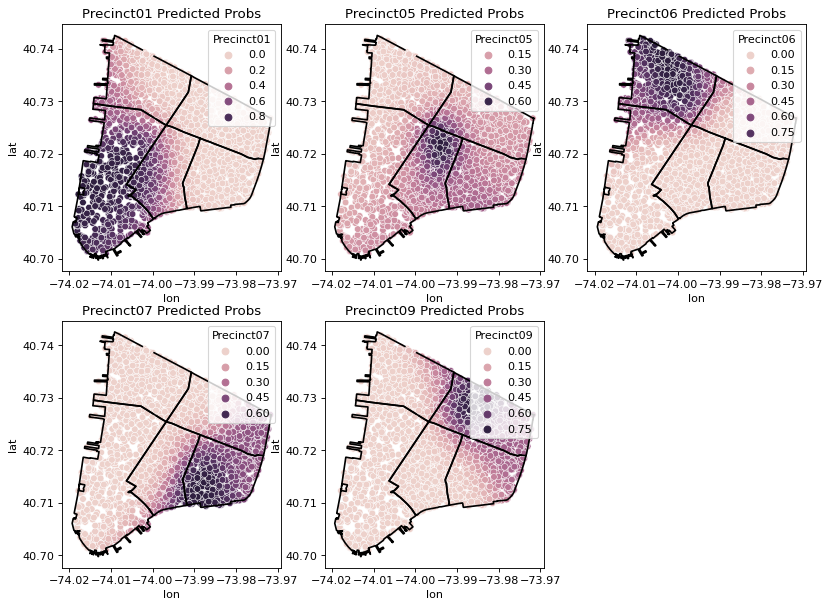

In [ ]:
plt.figure(figsize=(12,9))

plot_i = 231
for i in range(5):
    plt.subplot(plot_i + i)
    sns.scatterplot(x='lon', y='lat', hue=precincts[i], data=ovr_pred)
    plot_boundaries(manh_bounds)
    plt.title(precincts[i] + " Predicted Probs")

plt.show()

---

### &diams; Exercise 6

How do the probabilities predicted using the model for Precinct 1 compare to the probabilities predicted by the model fit solely to the Precinct 1 binary outcome? If they differ why do you think this is?

*The predicted probabilities for the 1st precinct has a much more complex boundary (circular vs a line). This arises due to the fact that each location now has 5 probabilities (one for each category) and we are normalizing these probabilities such that they sum to 1.*

---

### &diams; Exercise 7

How many parameters were estimated to fit this `ovr` logistic regression model? Don't forget to count the intercepts.

In [ ]:
print(m_ovr.named_steps["logisticregression"].intercept_)
print(m_ovr.named_steps["logisticregression"].coef_)

[-1.4885303  -1.84119752 -3.62532639 -5.4420286  -5.60382601]
[[-3.26310818 -1.62993888]
 [ 0.60260503 -0.77496494]
 [-1.85272168  4.58696056]
 [ 3.46803377 -3.55070857]
 [ 3.95639116  2.38989858]]


*The model has $5 \times 3 = 15$ parameters, 3 parameters for each category (`intercept`, `lat`, and `lon`).*

---

## 3.2 Multinomial

A slightly more principled approach for this kind of multi-class classification problem is to use a full multinomial likelihood when fitting the model (this involves fitting only a single model instead of 5 separate models, but each level still requires 3 parameters to be estimated).

We set up the model matrix and outcome vector in the same way and then fit them using `LogisticRegression` with `multi_class='multinomial'` instead of `'ovr'`. We again scale the features and  adjust `max_iter` to avoid coveregence issues.

In [ ]:
X = manh_tickets[['lon','lat']]
y = manh_tickets.precinct

m_mn = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='none', multi_class='multinomial', max_iter=1000)
).fit(X,y)

Once fit we can use the model to predict labels and calculate predicted probabilites for the testing locations.

In [ ]:
mn_pred = manh_test.copy()
mn_pred['pred_label'] = m_mn.predict(mn_pred[['lon','lat']])

mn_pred

,precinct,lon,lat,pred_label
0,Precinct01,-74.010330,40.720485,Precinct01
1,Precinct01,-74.005740,40.708015,Precinct01
2,Precinct01,-74.001993,40.707750,Precinct05
3,Precinct01,-74.005499,40.706179,Precinct01
4,Precinct01,-74.009585,40.726523,Precinct01
...,...,...,...,...
2495,Precinct09,-73.993883,40.725202,Precinct05
2496,Precinct09,-73.988460,40.729783,Precinct09
2497,Precinct09,-73.984370,40.725988,Precinct09
2498,Precinct09,-73.989221,40.723938,Precinct09


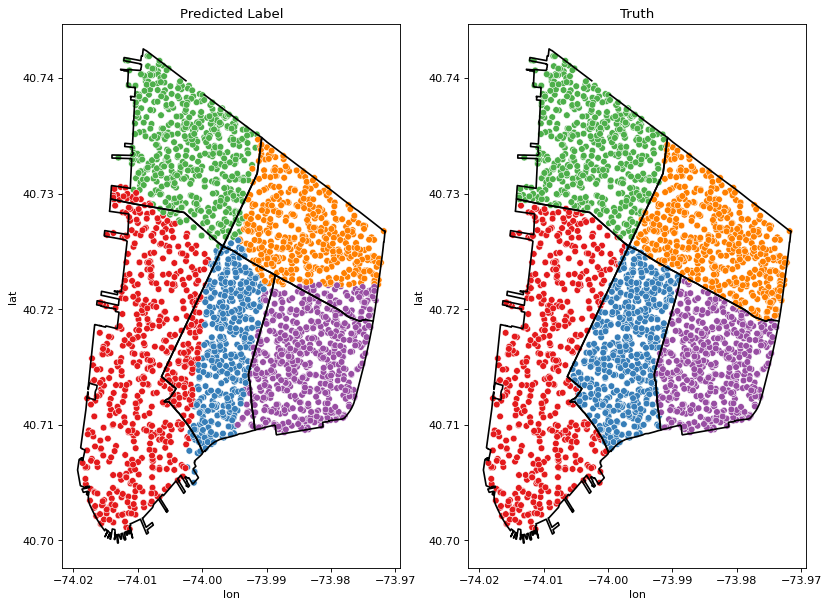

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(121)
sns.scatterplot(
    x='lon', y='lat', hue='pred_label', palette=precinct_pal,
    data=mn_pred, legend=None
).set_title("Predicted Label")
plot_boundaries(manh_bounds)

plt.subplot(122)
sns.scatterplot(
    x='lon', y='lat', hue='precinct',  palette=precinct_pal,
    data=mn_pred, legend=None
).set_title("Truth")
plot_boundaries(manh_bounds)

plt.show()

---

### &diams; Exercise 8

How does this model compare to our previous `'ovr'` model?

*This model appears to perform better, particularly for the 5th precinct.*

---

We can again also calculate the predicted probabilities for all 5 levels and compare them with our previous results.

In [ ]:
mn_pred = pd.concat(
    [ mn_pred,
    pd.DataFrame(
        # We round here for the sake of nicer printing in the table below
        data = np.round(m_mn.predict_proba(mn_pred[['lon','lat']]),4),
        columns = precincts
    ) ],
    axis=1
)

mn_pred

,precinct,lon,lat,pred_label,Precinct01,Precinct05,Precinct06,Precinct07,Precinct09
0,Precinct01,-74.010330,40.720485,Precinct01,0.9967,0.0027,0.0005,0.0000,0.0000
1,Precinct01,-74.005740,40.708015,Precinct01,0.8785,0.1212,0.0000,0.0003,0.0000
2,Precinct01,-74.001993,40.707750,Precinct05,0.4648,0.5240,0.0000,0.0112,0.0000
3,Precinct01,-74.005499,40.706179,Precinct01,0.8377,0.1616,0.0000,0.0006,0.0000
4,Precinct01,-74.009585,40.726523,Precinct01,0.9267,0.0020,0.0713,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...
2495,Precinct09,-73.993883,40.725202,Precinct05,0.0302,0.4396,0.1907,0.0226,0.3168
2496,Precinct09,-73.988460,40.729783,Precinct09,0.0000,0.0030,0.0251,0.0013,0.9706
2497,Precinct09,-73.984370,40.725988,Precinct09,0.0000,0.0030,0.0004,0.0345,0.9621
2498,Precinct09,-73.989221,40.723938,Precinct09,0.0006,0.1410,0.0076,0.1484,0.7024


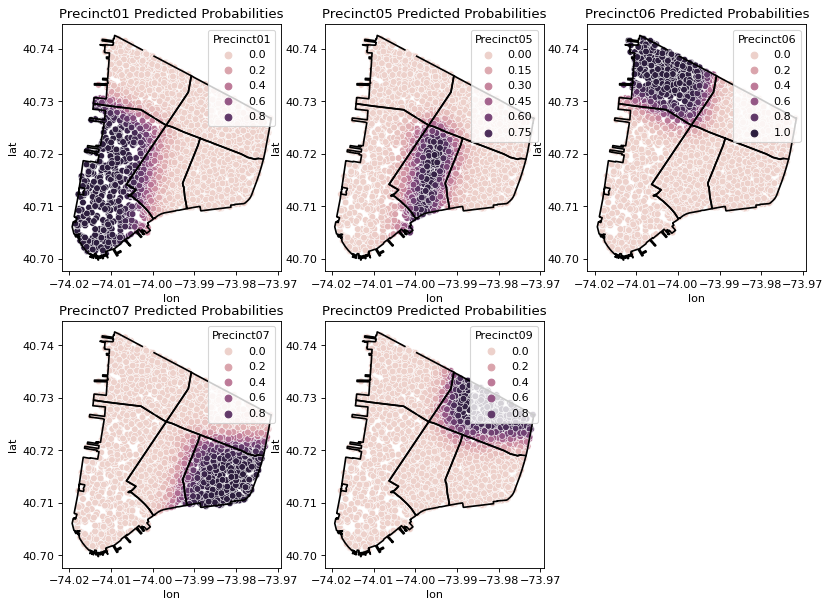

In [ ]:
plt.figure(figsize=(12,9))

plot_i = 231
for i in range(5):
    plt.subplot(plot_i + i)
    sns.scatterplot(x='lon', y='lat', hue=precincts[i], data=mn_pred)
    plot_boundaries(manh_bounds)
    plt.title(precincts[i] + " Predicted Probabilities")

plt.show()

---

### &diams; Exercise 9

Explain why both this model and the `'ovr'` model produced curved boundaries between the classes when the individual models only include `lat`, and `lon` as features (there is no interaction term).

*The ovr model normalizes the predicted probabilities such that they sum to 1 for each point, similarly this is an implicit requirement of the multinomial model. As such each model produces a linear boundary the interaction of these boundaries across the 5 catergories is what produces the more complex patterns we are seeing here.*

---

### &diams; Exercise 10

How many parameters were estimated to fit this `multinomial` logistic regression model? Don't forget to count the intercepts.

In [ ]:
print(m_ovr.named_steps["logisticregression"].intercept_)
print(m_ovr.named_steps["logisticregression"].coef_)

[-1.4885303  -1.84119752 -3.62532639 -5.4420286  -5.60382601]
[[-3.26310818 -1.62993888]
 [ 0.60260503 -0.77496494]
 [-1.85272168  4.58696056]
 [ 3.46803377 -3.55070857]
 [ 3.95639116  2.38989858]]


*The same as with the `ovr` model, 15.*

---

## 3.3 Multiclass scoring

As with everything else, scoring the predictive performance of a multiclass model is more complicated than scoring a binary classifier. To begin with, instead of having a $2\times2$ confusion matrix, we will not have a $k\times k$ confusion matrix to allow for each class to be misclassified as one of the others. sklearn provides the function `confusion_matrix` in the `metrics` submodule for reporting these results.

In [ ]:
from sklearn.metrics import confusion_matrix

The function returns a matrix containing the classification results with the true labels along the rows and the predicted labels along the columns.

In [ ]:
confusion_matrix(mn_pred.precinct, mn_pred.pred_label)

array([[473,  15,  12,   0,   0],
       [ 86, 379,   0,  27,   8],
       [ 19,   0, 477,   0,   4],
       [  0,   0,   0, 496,   4],
       [  0,   7,  10,  69, 414]])

From this we can see that the multinomial model correctly predicted 473 of the tickets from Precinct 1 and misclassified 15 as coming from Precinct 05, 12 from Precinct 06, and none from Precinct 07 or 09. 

---

### &diams; Exercise 11

Based on the confusion matrix, which precicnt caused the most difficulty for this model? Explain.

*As expected the 5th precinct has the most misclassified points (86+27+8) out of 500 locations, the 9th precinct comes after that with (7+10+69) missclassified locations.*

---

The confusion matrix is useful but is difficult to read and compare across models, to generate a more user friendly summary we can use the `classification_report` function also from the `metrics` submodule.

In [ ]:
from sklearn.metrics import classification_report

We can now use this function with both our `ovr` and `multinomial` models to better compare their performance.

In [ ]:
print("One-vs-rest model:")
print( classification_report(ovr_pred.precinct, ovr_pred.pred_label) )

One-vs-rest model:
              precision    recall  f1-score   support

  Precinct01       0.66      0.93      0.77       500
  Precinct05       0.84      0.36      0.51       500
  Precinct06       0.93      1.00      0.96       500
  Precinct07       0.83      0.98      0.90       500
  Precinct09       0.98      0.89      0.93       500

    accuracy                           0.83      2500
   macro avg       0.85      0.83      0.81      2500
weighted avg       0.85      0.83      0.81      2500



In [ ]:
print("Multinomial model:")
print( classification_report(mn_pred.precinct, mn_pred.pred_label) )

Multinomial model:
              precision    recall  f1-score   support

  Precinct01       0.82      0.95      0.88       500
  Precinct05       0.95      0.76      0.84       500
  Precinct06       0.96      0.95      0.95       500
  Precinct07       0.84      0.99      0.91       500
  Precinct09       0.96      0.83      0.89       500

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.89      2500
weighted avg       0.90      0.90      0.89      2500



Here the precision, recall, and f1-scores are calculated in the usual way for each class. The accuracy is the total proportion of observations that were correctly labeled and is a useful if somewhat limited summary of overall performance. The macro and weighted averages are discussed in sklearns documentation for [`precision_recall_fscore_support`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support).

When using these results to judge a model it is important to not rely on a single value as it is important to consider the entire model and how it performs overall as well as for each class. Additionally, situations with imbalanced classes can result in metrics like the accuracy to be overly optimistic.

---

### &diams; Exercise 11

Based on these summaries, which model do you think is performing better. Explain.

*Across the board the multinomial model is performing better (in terms of both class less statistics as well as the overall accuracy of the model).*

---

## 4. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF and turn it in on gradescope under the `mlp-week07` assignment.

In [ ]:
!jupyter nbconvert --to pdf mlp-week07.ipynb

[NbConvertApp] Converting notebook mlp-week07.ipynb to pdf
[NbConvertApp] Support files will be in mlp-week07_files/
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Making directory ./mlp-week07_files
[NbConvertApp] Writing 87545 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=004b30c9-ff82-422e-aa85-018ee725e790' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>